In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax

import icomo

In [5]:
# Function to calculate the modulating factor 'm' based on provided arguments
def m(args):
    # Calculate the modulating factor 'm' which depends on 'm_max', 'H_thres', 'm_eps', and 'H'
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - args["H"]) / args["m_eps"])
    )


# Function to calculate the testing rate of STI
def lambda_STI(args):
    # Calculate the lambda_STI considering different parameters and modulating factor 'm'
    return (
        args["lambda_0_a"]  # Baseline test rate
        + args["c"]
        * (1 - m(args))
        * args["beta_HIV"]
        * args["H"]
        * (1 - args["P_HIV"])  # HIV dependent term
        + args["lambda_P"]
        * args["P_HIV"]  # Proportional infection rate due to HIV prevalence
    )


# Function to calculate infection from asymptomatic STI individuals
def infect_ia(y, args):
    # Calculate the infection rate from asymptomatic STI individuals
    return (1 - m(args) * (1 - args["P_HIV"])) * args["beta_STI"] * y["Ia_STI"]


# Function to calculate infection from symptomatic STI individuals
def infect_is(y, args):
    # Calculate the infection rate from symptomatic STI individuals
    return (1 - m(args) * (1 - args["P_HIV"])) * args["beta_STI"] * y["Is_STI"]


# Main model function that defines the differential equations of the system
def model(t, y, args):
    cm = icomo.CompModel(y)  # Initialize the compartmental model

    # Basic STI dynamics
    cm.flow(
        "S_STI", "Ia_STI", args["asymptomatic"] * infect_ia(y, args)
    )  # Susceptible to asymptomatic
    cm.flow(
        "S_STI", "Is_STI", (1 - args["asymptomatic"]) * infect_is(y, args)
    )  # Susceptible to symptomatic
    cm.flow(
        "Ia_STI", "S_STI", args["gamma_STI"]
    )  # Asymptomatic to susceptible (recovery)
    cm.flow("Ia_STI", "T_STI", lambda_STI(args))  # Asymptomatic to tested and treatment
    cm.flow("Is_STI", "T_STI", args["lambda_0"])  # Symptomatic to tested and treatment
    cm.flow(
        "T_STI", "S_STI", args["gammaT_STI"]
    )  # Treatment to susceptible (immunity loss)

    # Vital dynamics (natural death or other forms of removal)
    cm.flow("Ia_STI", "S_STI", args["mu"])  # Death/removal from asymptomatic
    cm.flow("Is_STI", "S_STI", args["mu"])  # Death/removal from symptomatic
    cm.flow("T_STI", "S_STI", args["mu"])  # Death/removal from treatment

    # Return the differential changes
    return cm.dy


# Arguments for the model
args = {
    "beta_HIV": 0.6341 / 360.0,  # HIV infection rate per day
    "beta_STI": 0.0016 * 5.0,  # STI infection rate
    "mu": 1.0 / 45.0 / 360.0,  # Natural death rate per day
    "gamma_STI": 1.0 / 1.32 / 360.0,  # Recovery rate from asymptomatic STI per day
    "gammaT_STI": 1.0 / 14.0,  # Recovery rate from treated STI per day
    "lambda_0_a": 0.0,  # Baseline test rate for asymptomatic STI
    "lambda_0": 0.3 / 11.0,  # Baseline test rate for symptomatic STI
    "lambda_P": 1 / 3 / 360,  # Infection rate due to HIV prevalence
    "asymptomatic": 0.9,  # Proportion of asymptomatic infections
    "m_max": 0.8,  # Maximum modulating factor
    "H_thres": 0.1,  # HIV threshold
    "m_eps": 0.01,  # Small constant for smoothing
    "Phi_r": 40.0,  # Not used in the current model
    "H_tau": 20.0,  # Not used in the current model
    "c": 50.0,  # Scaling factor for HIV interaction term
    "H": 0.0,  # Initial HIV prevalence
    "P_HIV": 0.0,  # Initial proportion of HIV positive individuals
}

# Initial state of the compartments
y0 = {
    "S_STI": 0.99,  # Initial susceptible proportion
    "Ia_STI": 0.009,  # Initial asymptomatic proportion
    "Is_STI": 0.001,  # Initial symptomatic proportion
    "T_STI": 0.0,  # Initial treated proportion
}

In [6]:
# Define the time span for the simulation
ts = np.linspace(
    0, 3600 * 5, 3600
)  # Create an array of time points from 0 to 5 years, with 3600 steps

# Create an ODE integrator object using the icomo library
integrator_object = icomo.ODEIntegrator(
    ts_out=ts,  # Output time points
    t_0=min(ts),  # Initial time point
    ts_solver=ts,  # Time points for the solver to use
)

# Get the integration function for the model
integrator = integrator_object.get_func(
    model
)  # Returns a function that can be used to solve the ODEs defined in the 'model' function

In [7]:
# Define the ranges for H (HIV prevalence) and P (proportion of HIV positive individuals)
Hs = np.linspace(0, 0.15, 101)  # 101 points from 0 to 0.15
Ps = np.linspace(0, 0.9, 201)  # 201 points from 0 to 0.9

# Define different values for lambda_P (proportional infection rate due to HIV prevalence)
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

# Dictionary to store results for different lambda_P values
results = {}

# Loop over each lambda_P value
for lambda_P in lambda_P_values:
    res_size = [len(Hs), len(Ps)]  # Determine the size of the result matrices
    res_I = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic STI infections
    res_T = np.zeros(res_size)  # Initialize result matrix for treated STI infections
    res_infections = np.zeros(res_size)  # Initialize result matrix for total infections
    res_tests = np.zeros(res_size)  # Initialize result matrix for the number of tests
    check = np.zeros(res_size)  # Initialize matrix to check for convergence

    # Loop over each value of H and P
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            args_mod = args.copy()  # Copy the initial arguments
            args_mod["H"] = H  # Set current HIV prevalence
            args_mod["P_HIV"] = P  # Set current proportion of HIV positive individuals
            args_mod["lambda_P"] = lambda_P  # Set current lambda_P value

            # Integrate the model with the modified arguments
            output = integrator(y0=y0, constant_args=args_mod)

            # Get the final state of the system
            y1 = {key: value[-1] for key, value in output.items()}
            res_I[i, j] = output["Ia_STI"][
                -1
            ]  # Record the final asymptomatic STI infections
            res_T[i, j] = output["T_STI"][-1]  # Record the final treated STI infections
            res_infections[i, j] = (
                infect_is(y1, args_mod) + infect_ia(y1, args_mod)
            ) * y1[
                "S_STI"
            ]  # Calculate total infections
            res_tests[i, j] = (
                lambda_STI(args_mod) * y1["Ia_STI"]
            )  # Calculate the number of tests

            # Check for convergence by comparing the last and the second last values
            check[i, j] = (
                abs(output["Ia_STI"][-1] - output["Ia_STI"][-101])
                + abs(output["T_STI"][-1] - output["T_STI"][-101])
                + abs(output["Is_STI"][-1] - output["Is_STI"][-101])
            )

    # Store the results for the current lambda_P value
    results[lambda_P] = {
        "res_I": res_I,
        "res_T": res_T,
        "res_infections": res_infections,
        "res_tests": res_tests,
        "check": check,
    }

# Print the maximum value from the check matrix to ensure convergence
print(check.max())

0.0003396363487269134


<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\1927770004.py:30: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


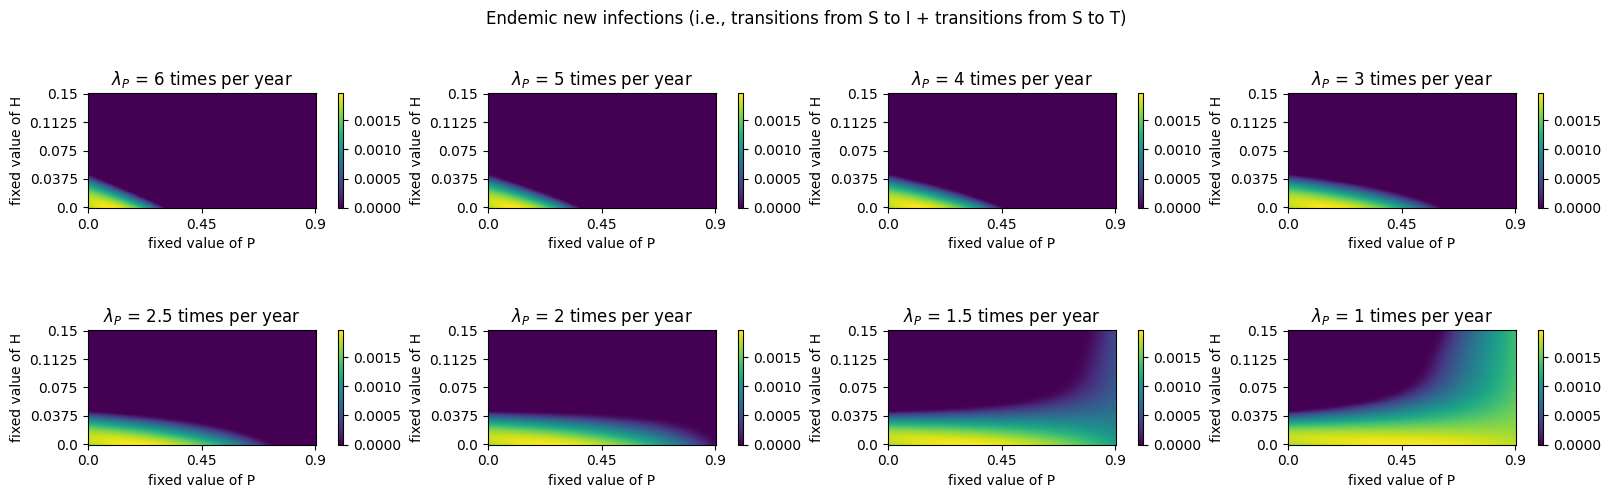

In [8]:
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_infections"].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5), constrained_layout=True
)

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle(
    "Endemic new infections (i.e., transitions from S to I + transitions from S to T)"
)

plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\32779317.py:32: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


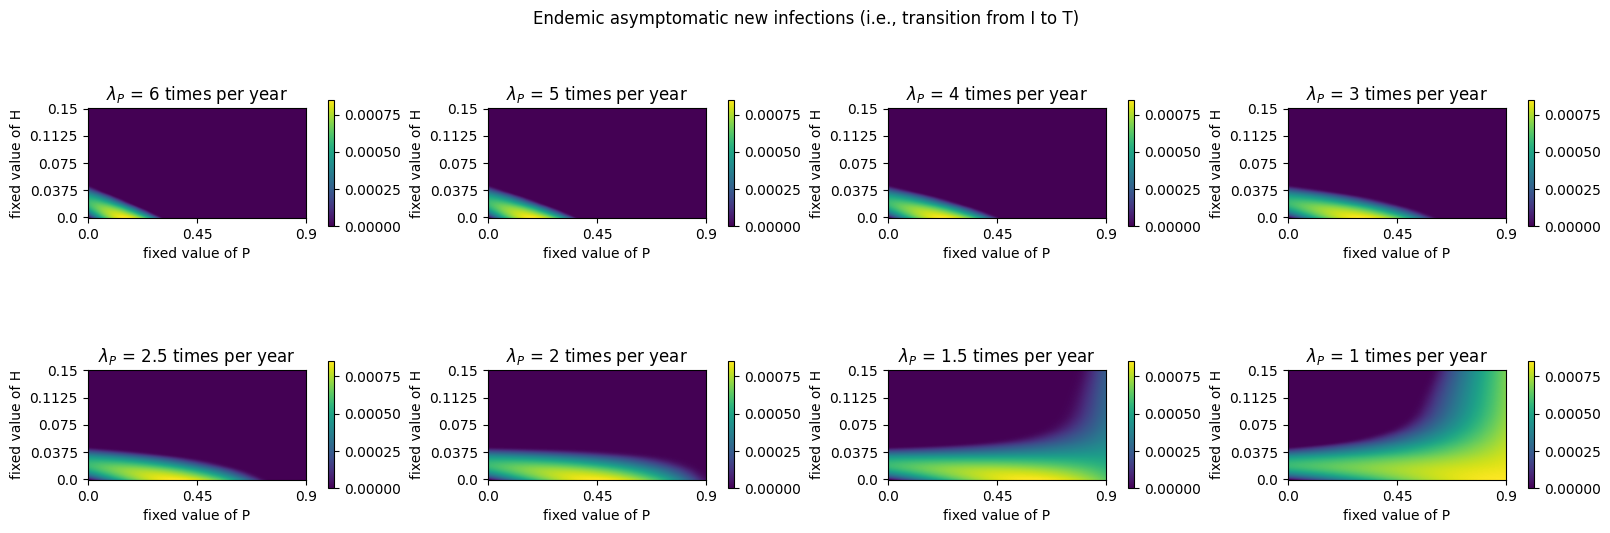

In [9]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_tests"].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_tests = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_tests, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("Endemic asymptomatic new infections (i.e., transition from I to T)")

plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\3164157755.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


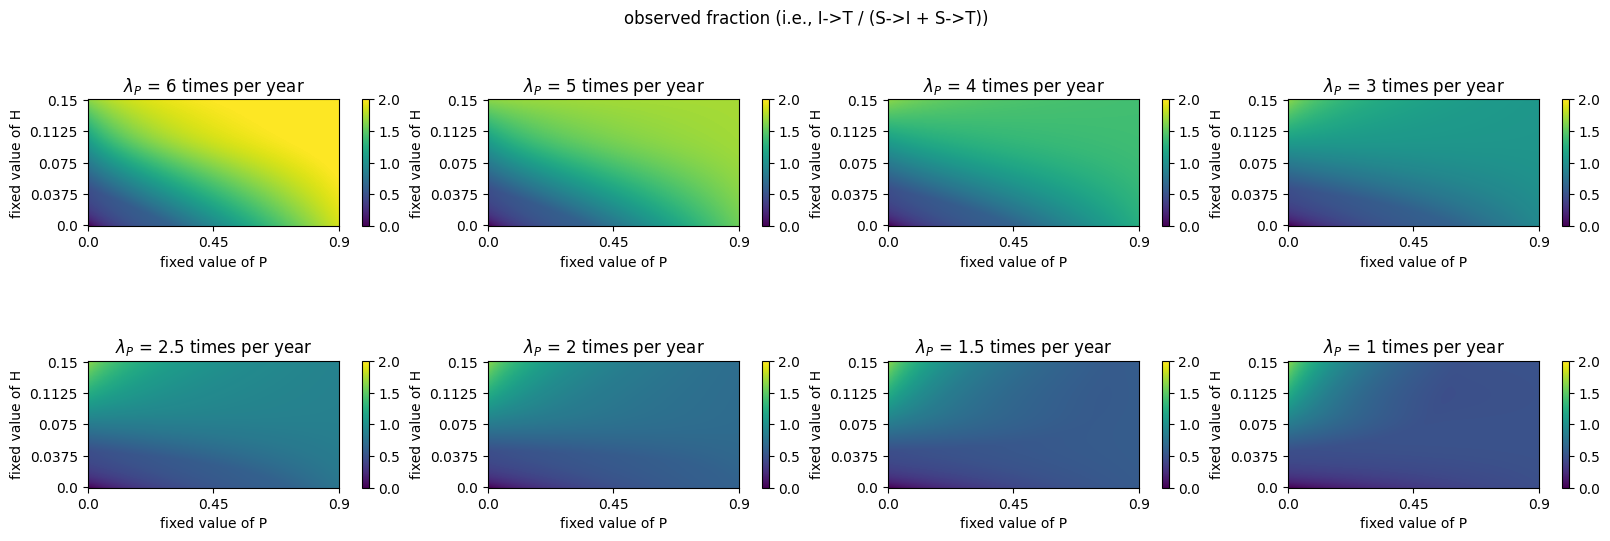

In [10]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    res_tests = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_tests / res_infections, origin="lower", vmin=0, vmax=2)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction (i.e., I->T / (S->I + S->T))")

plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\3721642146.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


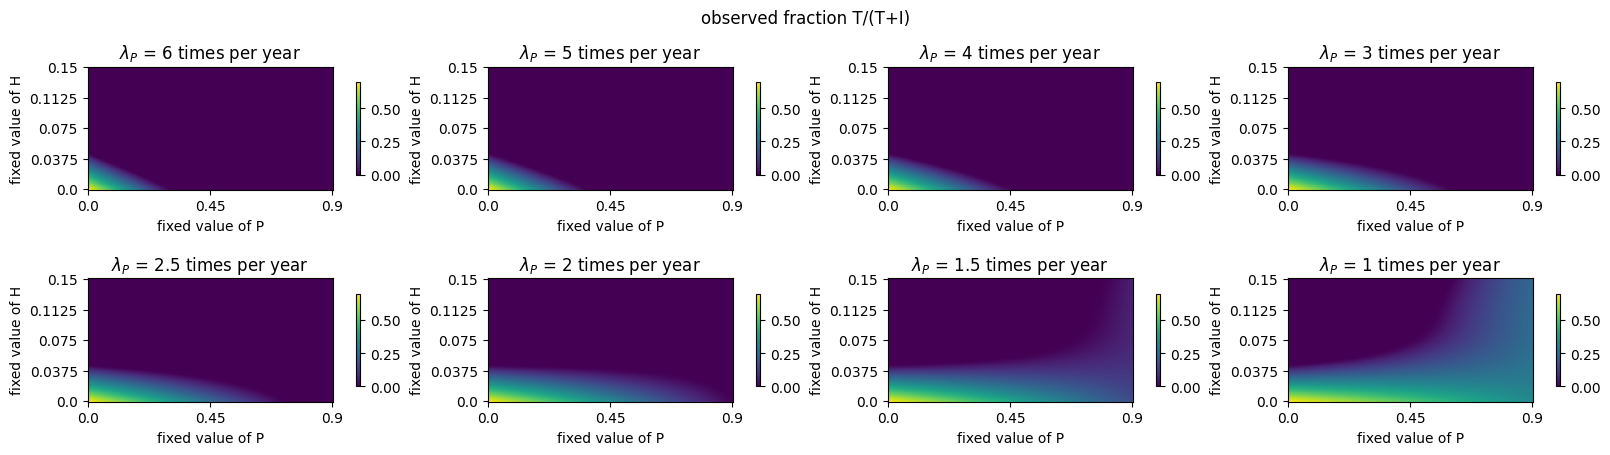

In [11]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]
num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 4.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_I = results[lambda_P]["res_I"]
    res_T = results[lambda_P]["res_T"]
    cax = ax.imshow(res_I - res_T, origin="lower", vmin=0, vmax=0.7)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction T/(T+I)")

plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\968539368.py:43: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_25860\968539368.py:52: SyntaxWarning: invalid escape sequence '\l'
  "$\lambda_{STI}$ = $\lambda_0$ + $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",


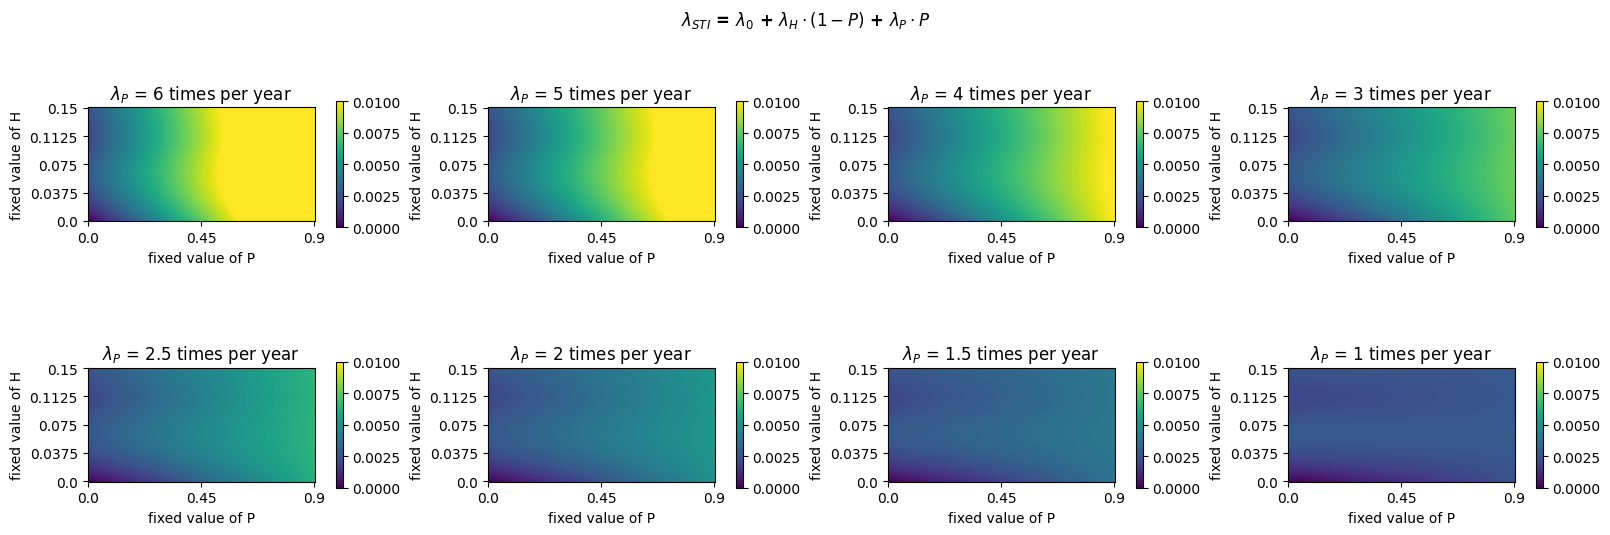

In [13]:
# Define parameters
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)


# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Plotting
num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)

for idx, lambda_P_val in enumerate(lambda_P_values):
    lambda_H = np.zeros([len(Hs), len(Ps)])
    lambda_P = np.zeros([len(Hs), len(Ps)])

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    total_lambda = lambda_P + lambda_H + args["lambda_0_a"]
    cax = ax.imshow(total_lambda, origin="lower", vmin=0, vmax=0.01)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle(
    "$\lambda_{STI}$ = $\lambda_0$ + $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
    fontweight="bold",
)

plt.show()